In [1]:
import pandas as pd
import numpy as np

In [2]:
songs = pd.read_csv('song-attributes.txt', sep="\t", header=None)
songs = songs.rename(columns={0:'song_id', 1:'album_id', 2:'artist_id', 3:'genre_id'})

In [3]:
genres = pd.read_csv('genre-hierarchy.txt', sep="\t", header=None)
genres = genres.rename(columns={0:'genre_id', 1:'parent_genre', 2:'level', 3:'genre_name'})

In [4]:
trdata = pd.read_csv('train_0.txt', sep="\t", header=None)
trdata = trdata.rename(columns={0:'user_id', 1:'song_id', 2:'rating'})

In [5]:
df = trdata.merge(songs, on='song_id').merge(genres, on='genre_id')
df.head()

,user_id,song_id,rating,album_id,artist_id,genre_id,parent_genre,level,genre_name
0,0,166,5,5303,7231,0,0,1,Unknown
1,2941,166,5,5303,7231,0,0,1,Unknown
2,3476,166,5,5303,7231,0,0,1,Unknown
3,3748,166,1,5303,7231,0,0,1,Unknown
4,4086,166,2,5303,7231,0,0,1,Unknown


In [10]:
df.shape

(76344627, 9)

In [12]:
df.isnull().sum()

user_id         0
song_id         0
rating          0
album_id        0
artist_id       0
genre_id        0
parent_genre    0
level           0
genre_name      0
dtype: int64

In [23]:
df['level'].unique()

array([1, 2, 3])

# Summary Statistics

In [24]:
df[['rating', 'genre_id', 'parent_genre', 'level']].describe()

,rating,genre_id,parent_genre,level
count,7.634463e+07,7.634463e+07,7.634463e+07,7.634463e+07
mean,3.153490e+00,1.677832e+01,1.670814e+01,1.013341e+00
std,1.599536e+00,4.307285e+01,4.289884e+01,1.266558e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,5.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,5.000000e+00,2.150000e+02,2.110000e+02,3.000000e+00


Observations:<br>
Average rating is a bit higher than 3 --> maybe there are more highly rated songs in this data
<br>
<br>
Genre columns seem to have a max of around 215 meaning there are over 200 genres to choose from however the average genre number seems to be closer to 16. The standard deviation is also very high indicating there is a large variance in the genre selection of the songs rated
<br>
<br>
Level column has a max of 3 indicating that there are 3 different levels assigned to every song but the first 3 quartiles fall into the 1 bucket --> majority of songs are in the first level 

<AxesSubplot:>

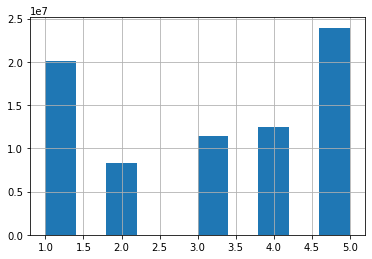

In [28]:
df['rating'].hist()

The distribution of ratings given by users in this dataset are fairly variated with similar counts in the 2-4 range and peaks at 1 and 4, showing that users tend to rate songs either very poorly or highly. This indicates that a good default metric for our model if that user has not rated a song yet, would be to give either a 1 or 5 depending on whether that user tends to rate more songs poorly or highly. 

<AxesSubplot:>

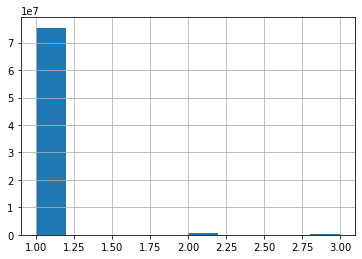

In [30]:
df['level'].hist()

The distribution of level is a tri modal distribution with a comparitively higher peak at level 1. This shows that most songs are attached to a single genre (probably niche) and there are only a few songs with parent genres in the level 2 and 3 hierarchies. This indicates that the feature to use in our model should be genre_id instead of parent_genre if many songs don't have a parent genre 

In [11]:
df[df['genre_name']=='Unknown'].shape[0]/df.shape[0]

0.8579403760791182

In [14]:
df[df['genre_id']==0].shape[0]/df.shape[0]

0.8579403760791182

Around 86% of the genre names are unknown indicating that this feature may not be a great indicator of predicting accurate ratings for a song and user

In [6]:
df[['rating', 'level']].corr()

,rating,level
rating,1.000000,0.004521
level,0.004521,1.000000


In [6]:
df[['rating', 'genre_id']].corr()

,rating,genre_id
rating,1.000000,0.020506
genre_id,0.020506,1.000000


No significant correlations -> model will have to rely on historical data per user to accurate predict ratings 

In [25]:
df['genre_name'].value_counts().sort_values()[:10]

Lounge                99
Indie Pop            115
Minimal Techno       158
Country Comedy       281
New Wave             336
Orchestral           619
Traditional Folk     707
Hard Rock           1056
Gospel              1469
Holiday             2337
Name: genre_name, dtype: int64

In [26]:
df['genre_name'].value_counts().sort_values(ascending=False)[:10]

Unknown               65499138
Rock                   5293264
Pop                    1744753
R&B                    1295667
Country                 567461
Classic Rock            355190
Rap                     338045
Comedy                  228634
Reggae                  104881
Adult Contemporary       84641
Name: genre_name, dtype: int64

In [15]:
high = df[df['rating']==5]
high.head()

,user_id,song_id,rating,album_id,artist_id,genre_id,parent_genre,level,genre_name
0,0,166,5,5303,7231,0,0,1,Unknown
1,2941,166,5,5303,7231,0,0,1,Unknown
2,3476,166,5,5303,7231,0,0,1,Unknown
5,5391,166,5,5303,7231,0,0,1,Unknown
6,5955,166,5,5303,7231,0,0,1,Unknown


In [17]:
high['genre_name'].value_counts().sort_values()[:10]

Country Comedy       20
Indie Pop            21
Minimal Techno       23
Lounge               39
New Wave             52
Traditional Folk    105
Orchestral          205
Gospel              237
Hard Rock           423
Funk                438
Name: genre_name, dtype: int64

In [18]:
high['genre_name'].value_counts().sort_values(ascending=False)[:10]

Unknown         20455849
Rock             1680086
Pop               521423
R&B               445233
Country           192394
Rap               107632
Classic Rock      106113
Comedy             84110
Reggae             45212
Folk               29137
Name: genre_name, dtype: int64

In [21]:
high['level'].value_counts()

1    23647130
2      251172
3       38143
Name: level, dtype: int64

In [22]:
low = df[df['rating']==1]
low.head()

,user_id,song_id,rating,album_id,artist_id,genre_id,parent_genre,level,genre_name
3,3748,166,1,5303,7231,0,0,1,Unknown
10,9351,166,1,5303,7231,0,0,1,Unknown
20,15590,166,1,5303,7231,0,0,1,Unknown
66,46161,166,1,5303,7231,0,0,1,Unknown
69,47528,166,1,5303,7231,0,0,1,Unknown


In [23]:
low['genre_name'].value_counts().sort_values()[:10]

Lounge                28
Indie Pop             36
Minimal Techno        98
New Wave             122
Orchestral           139
Hard Rock            188
Country Comedy       218
Traditional Folk     435
Movie Soundtracks    495
Early Blues          509
Name: genre_name, dtype: int64

In [24]:
low['genre_name'].value_counts().sort_values(ascending=False)[:10]

Unknown               17571668
Rock                   1134954
Pop                     454876
R&B                     361210
Country                 129520
Rap                     102721
Classic Rock             79843
Comedy                   53366
Adult Contemporary       18810
Reggae                   17180
Name: genre_name, dtype: int64

In [27]:
df['genre_name'].unique()

array(['Unknown', 'Classic Rock', 'Rock', 'Pop', 'Country', 'R&B',
       'Adult Contemporary', 'Easy Listening', 'Shows &amp; Movies',
       'Rap', 'Classic R&B', 'Mainstream Pop', 'World', 'Vocal Jazz',
       'Reggae', 'Modern Rock', 'R&B Gospel', 'Folk', 'Christmas',
       'Adult Alternative', 'Comedy', 'Industrial Rock', 'Blues', 'Disco',
       'Alt-Country', 'Religious', 'Jazz', 'Traditional Folk', 'Holiday',
       'Speed Metal', 'Death Metal', 'New Age', 'Mainstream Dance',
       'Modern Blues', 'Movie Soundtracks', 'Folk-Pop',
       'Electronic/Dance', 'Latin', 'Modern R&B', 'Classical', 'Funk',
       'Ambient Tech', 'Metal', 'Early Blues', 'Punk', 'Indie Rock',
       'New Wave', 'Gospel', 'Indie Pop', 'Pop Metal', 'Soft Pop',
       'Techno', 'Vocal Standards', 'Lounge', 'Orchestral',
       'Country Comedy', 'Minimal Techno', 'Hard Rock'], dtype=object)

In [29]:
df[df['genre_name']=='Rock']['rating'].value_counts(normalize=True)

5    0.317401
1    0.214415
4    0.187116
3    0.165344
2    0.115725
Name: rating, dtype: float64

In [30]:
df[df['genre_name']=='Pop']['rating'].value_counts(normalize=True)

5    0.298852
1    0.260711
4    0.168896
3    0.154209
2    0.117332
Name: rating, dtype: float64

In [31]:
df[df['genre_name']=='Punk']['rating'].value_counts(normalize=True)

5    0.336842
1    0.233168
4    0.175174
3    0.150546
2    0.104270
Name: rating, dtype: float64

After some analysis on ratings across different genres, the data shows that the bigger genres like Pop and Rock which have a higher number of overall ratings, are also ranked with the most number of 5 and 1 ratings as well. This shows that because of the distribution of ratings across genres being unequal, knowing the genre does not indicate whether it will be more likely to get ranked higher or not. This also further affirms the close to 0 correlation coefficient between genre and rating. 